In [33]:
# tf tools
import tensorflow as tf
# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)
# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
from tensorflow.keras import layers
# generic model object
from tensorflow.keras.models import Model
# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import numpy as np
import matplotlib.pyplot as plt

# for json files
import pandas as pd
import os
import json


In [89]:
# plotting function
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss", linestyle=":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc", linestyle=":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    #plt.show()

In [36]:
# Load the json metadata (containing the labels)
test_df = pd.read_json(os.path.join("..", "..", "..", "431824", "images", "metadata","test_data.json" ), lines=True)
train_df = pd.read_json(os.path.join("..", "..", "..", "431824", "images", "metadata","train_data.json" ), lines=True)
val_df = pd.read_json(os.path.join("..", "..", "..", "431824", "images", "metadata","val_data.json" ), lines=True)

In [37]:
# creating random samples to make machine faster
test_df = test_metadata.sample(n=75) #125
train_df = train_metadata.sample(n=250) #500
val_df = val_metadata.sample(n=50) #100

In [123]:
#train_generator = ImageDataGenerator(
#    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#)
#val_generator = ImageDataGenerator(
#    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#)
#test_generator = ImageDataGenerator(
#    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
#)

# Generator train data
train_datagen = ImageDataGenerator(horizontal_flip=True,
                                    rotation_range=20,
                                    rescale=1/255
)
# Generator test data
test_datagen = ImageDataGenerator(
                                rescale=1./255.
)

In [124]:
images_dir = os.path.join("..", "..", "..", "431824")
TARGET_size = (224, 224)
BATCH_size = 32

# Generating training data
train_images = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory = images_dir,
    x_col ='image_path',
    y_col ='class_label',
    target_size = TARGET_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = BATCH_size,
    shuffle = True,
    seed = 42,
    subset ='training'
)

# Generating test data
test_images = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    directory = images_dir,
    x_col ='image_path',
    y_col ='class_label',
    target_size = TARGET_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = BATCH_size,
    shuffle = False
)

# Generatig validation data
val_images = train_datagen.flow_from_dataframe(
    dataframe = val_df,
    directory = images_dir, 
    x_col ='image_path',
    y_col ='class_label',
    target_size = TARGET_size,
    color_mode ='rgb',
    class_mode ='categorical',
    batch_size = BATCH_size,
    shuffle = True,
    seed = 42,
)

Found 250 validated image filenames belonging to 15 classes.
Found 75 validated image filenames belonging to 15 classes.
Found 50 validated image filenames belonging to 15 classes.


In [125]:
# load the VGG16 model without classifier layers
model = VGG16(include_top=False,
              pooling='avg', 
              input_shape=(224, 224, 3)) # set to fit the size of the indo images
              
# mark loaded layers as not trainable (freeze all weights)
for layer in model.layers: 
    layer.trainable = False

In [126]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output) # flatten the images
bn = BatchNormalization()(flat1) # batch normalization layer
class1 = Dense(256, 
               activation ='relu')(bn)
class2 = Dense(128, 
               activation = 'relu')(class1)
output = Dense(15, 
               activation ='softmax')(class2)

# define new model
model = Model(inputs = model.inputs, 
              outputs = output)

In [127]:
# compile 
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)
sgd = SGD(learning_rate=lr_schedule)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# summarize model
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [128]:
# fit model to indo fashion and train model
history = model.fit(
    train_images, 
    steps_per_epoch = len(train_images),
    validation_data  = val_images,
    validation_steps = len(val_images),
    epochs = 10)

Epoch 1/10


2023-04-24 16:31:08.721610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


KeyboardInterrupt: 

/tmp/ipykernel_5711/1849079396.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


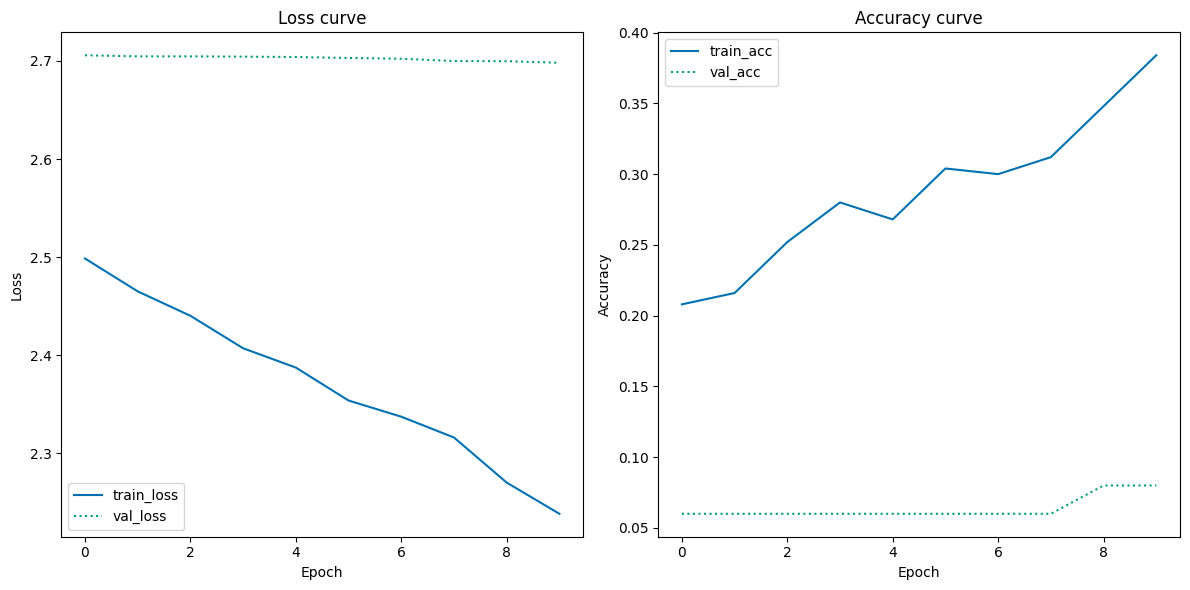

In [90]:
# Training history plot
plot_history(history, 10)
output_path = os.path.join("..", "out", "train_and_val_plots.png")
plt.savefig(output_path, dpi = 100)

In [121]:
#Kaggle
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

2023-04-24 16:22:57.479789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


3/3 [==============================] - 2s 488ms/step


In [122]:
# Create classification report
y_test = list(test_df.class_label)
report = classification_report(y_test, pred)

# Save classification report in "out"
file_path = os.path.join("..", "out", "classification_report.txt")

/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/coder/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
